In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [ ]:
PATH_DATA = r'MTB_DATA_CLEANED_FILTER_10_25_21.CSV'
data = pd.read_csv(PATH_DATA).drop(['AGEG'], axis = 1)

# Auxiliar Functions

In [ ]:

def categorizeVariable(dataTestModel,dataTrainModel, variable, bins, labels,drop_first):

  """
  Function to split a numerical variable into multiple categories.

  *dataTestModel: Test data to validate the prediction model
  *dataTrainModel: Train data to train the model 
  *variable: numerical variable to split into bins 
  *bins: Bins where split the information 
  *labels: Labels for each of the new categories created
  *drop_first: Boolean variable to know if the first category must be dropped
  """
  # Spliting the test data
  dataTestModel[variable] = pd.cut(dataTestModel[variable],bins=bins,labels=labels)
  dummies = pd.get_dummies(dataTestModel[variable], prefix = variable,drop_first=drop_first)
  dataTestModel = pd.concat((dataTestModel, dummies), axis = 1).drop(variable, axis = 1)
  
  # Spliting the train data
  dataTrainModel[variable] = pd.cut(dataTrainModel[variable],bins=bins,labels=labels)
  dummies = pd.get_dummies(dataTrainModel[variable], prefix = variable,drop_first=drop_first)
  dataTrainModel = pd.concat((dataTrainModel, dummies), axis = 1).drop(variable, axis = 1)
  return dataTestModel,dataTrainModel


def getModel(dataTrain):
  """
  Function to train a logistic regression model without penalty
  
  *dataTrain: Data to train the model
  """
  xTrain = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
  yTrain = dataTrain.PRBC 
  model = LogisticRegression(
      random_state=123,
      penalty = 'none',
      max_iter = 10000,
      solver = 'saga'
      ).fit(
          xTrain,
          yTrain
          )
      
  return model

def getMetrics(model, dataTest = None, xTest = None, yTest = None):
  """
  Function to get the performance metrics of any model.

  *model: Model to evalauate.
  *dataTest: If the information is parsed as one single dataframe (both X and y)
  *xTest: prediction variables to tes
  *yTest: Response variables to test
  """
  if type(dataTest) == pd.core.frame.DataFrame:
    xTest = dataTest.drop(['PRBC','REFERENCE'], axis = 1).copy()
    yTest = dataTest.PRBC.copy()
    
  probs = model.predict_proba(xTest)[:,1] 
  fpr, tpr, thr = roc_curve(yTest,probs)
  aucValue = auc(fpr, tpr)

  # With this, I retrieve the best threshold based on the value that 
  # minimize the distance to (1,1) in sensitivity vs specificity
  bestThrIndex = np.argmin(((tpr - 1)**2 + fpr ** 2)**(1/2))
  bestSpecificity = 1-fpr[bestThrIndex]
  bestSensitivity = tpr[bestThrIndex]
  bestThr = thr[bestThrIndex]
  yPred = ((probs >= bestThr) * 1)
  f1 = f1_score(yTest,yPred)
  tn, fp, fn, tp = confusion_matrix(yTest, yPred).ravel()
  ppv = tp / (tp + fp)
  fpv = tn / (fn + tn)
  distance = ((1 - bestSensitivity) ** 2 + (1 - bestSpecificity) ** 2)**(1/2)
  return bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1, distance

#Spliting data

In [ ]:
# Spliting the data into train and test
# I splited independently the positive and negative cases to mantein the proportion of the information

dataPositive = data[data.PRBC == 1].copy()
dataNegative = data[data.PRBC == 0].copy()
dataPositiveTrain, dataPositiveTest, _, _ = train_test_split(
    dataPositive, 
    dataPositive, 
    test_size=0.2, 
    random_state=0
    )

dataNegativeTrain, dataNegativeTest, _, _ = train_test_split(
    dataNegative, 
    dataNegative, 
    test_size=0.2, 
    random_state=0
    )

dataTrain = pd.concat((dataPositiveTrain.copy(), dataNegativeTrain.copy())).sample(frac=1, random_state=0).reset_index(drop = True)
dataTest = pd.concat((dataPositiveTest.copy(), dataNegativeTest.copy())).sample(frac=1, random_state=0).reset_index(drop = True)


In [ ]:
# Generating others 4 train and test dataset to apply a 5-fold cross validation
dataTrain_kfold = [dataTrain.copy()] 
dataTest_kfold = [dataTest.copy()]
kf = KFold(n_splits=4)
dataPositive_kfolds_test = []
dataPositive_kfolds_train = []
dataNegative_kfolds_test = []
dataNegative_kfolds_train = []

# Generating new positive train and test datasets 
for train_index, test_index in kf.split(dataPositiveTrain):
  
  dataPositive_kfolds_test.append(dataPositiveTrain.iloc[test_index].copy())
  dataPositive_kfolds_train.append(dataPositiveTrain.iloc[train_index].copy())

# Generating new negative train and test datasets 
for train_index, test_index in kf.split(dataNegativeTrain):
  
  dataNegative_kfolds_test.append(dataNegativeTrain.iloc[test_index].copy())
  dataNegative_kfolds_train.append(dataNegativeTrain.iloc[train_index].copy())

#Concatenating all the positive and negative train datasets into one single list
dataNegative_kfolds_train = [pd.concat((i,dataNegativeTest)) for i in dataNegative_kfolds_train]
dataPositive_kfolds_train = [pd.concat((i,dataPositiveTest)) for i in dataPositive_kfolds_train]

#Mergin the positive and negative train data into a single one
for i,j in zip(dataNegative_kfolds_train, dataPositive_kfolds_train):
  dataTrain_kfold.append(pd.concat((i,j)))

#Mergin the positive and negative test data into a single one
for i,j in zip(dataNegative_kfolds_test, dataPositive_kfolds_test):
  dataTest_kfold.append(pd.concat((i,j)))

# ABC Score

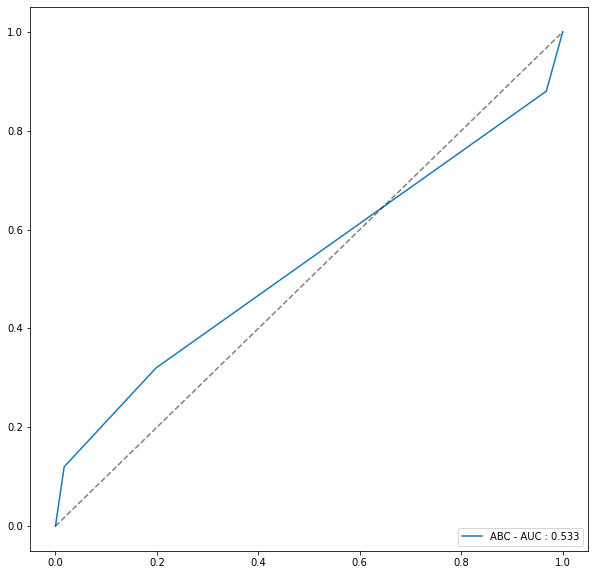

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_test['ABC'] = 0
X_test['ABC'] = X_test['ABC'] + (X_test.SBP > 90) * 1
X_test['ABC'] = X_test['ABC'] + (X_test.HR > 120) * 1
X_test['ABC'] = X_test['ABC'] + X_test.PNR
X_test['ABC'] = X_test['ABC'] + ((X_test.FC + X_test.FRLPA) > 0) * 1
y_pred = (X_test['ABC'] >= 2) * 1
fpr_ABC, tpr_ABC, thr_ABC = roc_curve(y_test,X_test['ABC'])

auc_ABC = auc(fpr_ABC, tpr_ABC)

#Plotting the models
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.legend(loc='lower right')

In [ ]:
#Validating with kfold cross validation
metrics_ABC = []
for test_ in dataTest_kfold.copy():

  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_.PRBC
  X_test_['ABC'] = 0
  X_test_['ABC'] = X_test_['ABC'] + (X_test_.SBP > 90) * 1
  X_test_['ABC'] = X_test_['ABC'] + (X_test_.HR > 120) * 1
  X_test_['ABC'] = X_test_['ABC'] + X_test_.PNR
  X_test_['ABC'] = X_test_['ABC'] + ((X_test_.FC + X_test_.FRLPA) > 0) * 1
  y_pred = (X_test_['ABC'] >= 3) * 1
  fpr, tpr, thr = roc_curve(y_test_,X_test_['ABC'])
  f1 = f1_score(y_test_,y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test_, y_pred).ravel()
  ppv = tp / (tp + fp)
  fpv = tn / (fn + tn)
  specificity = tn / (tn + fp)
  sensitivity = tp / (tp + fn)
  aucValue = auc(fpr, tpr)
  distance = ((specificity - 1) ** 2 + (sensitivity - 1) ** 2)**(1/2)
  
  metrics_ABC.append([sensitivity, specificity, 2, aucValue, ppv, fpv, f1, distance])

#Getting the metrics 
metrics_ABC = pd.DataFrame(metrics_ABC, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1', 'distance'])
metrics_ABC = pd.DataFrame((metrics_ABC.mean(), metrics_ABC.std()), index = ['modelABC-mean', 'modelABC-std']).T
metrics_ABC.T

# RABT Score

In [ ]:
#Validating with kfold cross validation
metrics_RABT = []
for test_ in dataTest_kfold.copy():

  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_.PRBC
  X_test_['RABT'] = 0
  X_test_['RABT'] = X_test_['RABT'] + ((X_test_.HR / X_test_.SBP) > 1) * 1
  X_test_['RABT'] = X_test_['RABT'] + X_test_.SPF
  X_test_['RABT'] = X_test_['RABT'] + X_test_.PNR
  X_test_['RABT'] = X_test_['RABT'] + ((X_test_.FC + X_test_.FRLPA) > 0) * 1
  y_pred = (X_test_['RABT'] >= 2) * 1
  fpr, tpr, thr = roc_curve(y_test_,X_test_['RABT'])
  f1 = f1_score(y_test_,y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test_, y_pred).ravel()
  ppv = tp / (tp + fp)
  fpv = tn / (fn + tn)
  specificity = tn / (tn + fp)
  sensitivity = tp / (tp + fn)
  aucValue = auc(fpr, tpr)
  distance = ((specificity - 1) ** 2 + (sensitivity - 1) ** 2)**(1/2)
  metrics_RABT.append([sensitivity, specificity, 2, aucValue, ppv, fpv, f1, distance])

#Getting the metrics 
metrics_RABT = pd.DataFrame(metrics_RABT, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1', 'distance'])
metrics_RABT = pd.DataFrame((metrics_RABT.mean(), metrics_RABT.std()), index = ['modelRABT-mean', 'modelRABT-std']).T
metrics_RABT.T

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_test['RABT'] = 0
X_test['RABT'] = X_test['RABT'] + ((X_test.HR / X_test.SBP) > 1) * 1
X_test['RABT'] = X_test['RABT'] + X_test.SPF
X_test['RABT'] = X_test['RABT'] + X_test.PNR
X_test['RABT'] = X_test['RABT'] + ((X_test.FC + X_test.FRLPA) > 0) * 1
y_pred = (X_test['RABT'] >= 2) * 1
fpr_RABT, tpr_RABT, thr_RABT = roc_curve(y_test,X_test['RABT'])

auc_RABT = auc(fpr_RABT, tpr_RABT)

#Plotting the models
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')

plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.legend(loc='lower right')

# Logistic Regression

## Partitions

In [ ]:
# Partitions used at the moment to realize the experiments.
partitions = {
    'SBP': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,115,175,220,1000],
            'labels' : ['C0','C1','C2','C3'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,90,120,1000],
            'labels' : ['C0','C1','C2'],
            'drop_first' : True
        },
        'partition_3': {
            'description':'commonRanges',
            'bins' : [0,140,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        }
    },
    'DBP': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,62.5,111,187.5,1000],
            'labels' : ['C0','C1','C2','C3'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,90,120,1000],
            'labels' : ['C0','C1','C2'],
            'drop_first' : True
        },
        'partition_3': {
            'description':'commonRanges',
            'bins' : [0,90,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        }
    },
    'RR': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,10.5,21.5,39,47,1000],
            'labels' : ['C0','C1','C2','C3','C4'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,20,30,1000],
            'labels' : ['C0','C1','C2'],
            'drop_first' : True
        },
        'partition_3': {
            'description':'commonRanges',
            'bins' : [0,20,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        }
    },
    'O2': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,62,77,95,1000],
            'labels' : ['C0','C1','C2','C3'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,90,95,1000],
            'labels' : ['C0','C1','C2'],
            'drop_first' : True
        },
        'partition_3': {
            'description':'commonRanges',
            'bins' : [0,95,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        }
    },
    'HR': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,26,51,114,1000],
            'labels' : ['C0','C1','C2','C3'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,90,120,1000],
            'labels' : ['C0','C1','C2'],
            'drop_first' : True
        },
        'partition_3': {
            'description':'commonRanges',
            'bins' : [0,120,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        }
    },
    'AGE': {
        'partition_1':{
            'description':'graphic',
            'bins' : [0,39,1000],
            'labels' : ['C0','C1'],
            'drop_first' : True
        },
        'partition_2':{
            'description':'identified',
            'bins' : [0,20,40,60,80,1000],
            'labels' : ['C0','C1','C2','C3','C4'],
            'drop_first' : True
        }
    },
    'GCSEO': {
        'partition_1':{
            'description':'categorical',
            'bins' : [0,1,2,3,4],
            'labels' : ['C1','C2','C3','C4'],
            'drop_first' : False
        }
    },
    'GCSVR': {
        'partition_1':{
            'description':'categorical',
            'bins' : [0,1,2,3,4,5],
            'labels' : ['C1','C2','C3','C4','C5'],
            'drop_first' : False
        }
    },
    'GCSMR': {
        'partition_1':{
            'description':'categorical',
            'bins' : [0,1,2,3,4,5,6],
            'labels' : ['C1','C2','C3','C4','C5','C6'],
            'drop_first' : False
        }
    }
}

## Models

In [ ]:
# Selecting the variables used for each model in logistic regression
variables_model3 = ['REFERENCE','AGE','SBP','O2','HR','GCSVR','PLRN','FC','FRLPA','PNR','BLR','PRBC']
variables_model4 = ['REFERENCE','AGE','SBP','O2','HR','GCSVR','PLRN','PLRA','FC','FRLPA','PNR','BLR','PRBC']
variables_model5 = ['REFERENCE','AGE','SBP','O2','HR','GCSMR','BLR','PRBC']

data_train_model1 = dataTrain.copy()
data_train_model2 = dataTrain.copy()
data_train_model3 = dataTrain.copy()
data_train_model4 = dataTrain.copy()
data_train_model5 = dataTrain.copy()

data_train_model3 = data_train_model3[variables_model3]
data_train_model4 = data_train_model4[variables_model4]
data_train_model5 = data_train_model5[variables_model5]

data_test_model1 = dataTest.copy()
data_test_model2 = dataTest.copy()
data_test_model3 = dataTest.copy()
data_test_model4 = dataTest.copy()
data_test_model5 = dataTest.copy()

data_test_model3 = data_test_model3[variables_model3]
data_test_model4 = data_test_model4[variables_model4]
data_test_model5 = data_test_model5[variables_model5]

# Setting the partitions used in each model
partition_model2 = ['DBP-partition_1','RR-partition_1','O2-partition_1','GCSEO-partition_1']
partition_model4 = ['GCSVR-partition_1']
partition_model5 = ['AGE-partition_1','O2-partition_1']

#Spliting the variables for model 2
for var in partition_model2:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    data_test_model2,data_train_model2 = categorizeVariable(data_test_model2,data_train_model2, variable, bins, labels,drop_first)

#Spliting the variables for model 4
for var in partition_model4:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    data_test_model4,data_train_model4 = categorizeVariable(data_test_model4,data_train_model4, variable, bins, labels,drop_first)

#Spliting the variables for model 5
for var in partition_model5:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    data_test_model5,data_train_model5 = categorizeVariable(data_test_model5,data_train_model5, variable, bins, labels,drop_first)

In [ ]:
#Getting the best logistic regression models
model1 = getModel(data_train_model1)
model2 = getModel(data_train_model2)
model3 = getModel(data_train_model3)
model4 = getModel(data_train_model4)
model5 = getModel(data_train_model5)

KeyboardInterrupt: ignored

In [ ]:
#Getting the predictions for each model
X_test_model1 = data_test_model1.drop(['REFERENCE','PRBC'], axis = 1)
X_test_model2 = data_test_model2.drop(['REFERENCE','PRBC'], axis = 1)
X_test_model3 = data_test_model3.drop(['REFERENCE','PRBC'], axis = 1)
X_test_model4 = data_test_model4.drop(['REFERENCE','PRBC'], axis = 1)
X_test_model5 = data_test_model5.drop(['REFERENCE','PRBC'], axis = 1)
y_test_model1 = data_test_model1['PRBC']
y_test_model2 = data_test_model2['PRBC']
y_test_model3 = data_test_model3['PRBC']
y_test_model4 = data_test_model4['PRBC']
y_test_model5 = data_test_model5['PRBC']

y_probs_1 = model1.predict_proba(X_test_model1)[:,1]
y_probs_2 = model2.predict_proba(X_test_model2)[:,1]
y_probs_3 = model3.predict_proba(X_test_model3)[:,1]
y_probs_4 = model4.predict_proba(X_test_model4)[:,1]
y_probs_5 = model5.predict_proba(X_test_model5)[:,1]

#Getting the values to plot the ROC curve
fpr_m1, tpr_m1, _ = roc_curve(y_test_model1,  y_probs_1)
fpr_m2, tpr_m2, _ = roc_curve(y_test_model2,  y_probs_2)
fpr_m3, tpr_m3, _ = roc_curve(y_test_model3,  y_probs_3)
fpr_m4, tpr_m4, _ = roc_curve(y_test_model4,  y_probs_4)
fpr_m5, tpr_m5, _ = roc_curve(y_test_model5,  y_probs_5)

#Getting the AUC values for each model
auc_m1 = auc(fpr_m1, tpr_m1)
auc_m2 = auc(fpr_m2, tpr_m2)
auc_m3 = auc(fpr_m3, tpr_m3)
auc_m4 = auc(fpr_m4, tpr_m4)
auc_m5 = auc(fpr_m5, tpr_m5)

#Plotting the ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Model 1 - AUC : {auc_m1:.3f}')
plt.plot(fpr_m2, tpr_m2, label = f'Model 2 - AUC : {auc_m2:.3f}')
plt.plot(fpr_m3, tpr_m3, label = f'Model 3 - AUC : {auc_m3:.3f}')
plt.plot(fpr_m4, tpr_m4, label = f'Model 4 - AUC : {auc_m4:.3f}')
plt.plot(fpr_m5, tpr_m5, label = f'Model 5 - AUC : {auc_m5:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])

plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
#Copying the kfold train data into new objects
data_train_model1 = dataTrain_kfold.copy()
data_train_model2 = dataTrain_kfold.copy()
data_train_model3 = dataTrain_kfold.copy()
data_train_model4 = dataTrain_kfold.copy()
data_train_model5 = dataTrain_kfold.copy()

#Selecting the variables used for each model in each partition for train data
data_train_model3 = [_[variables_model3] for _ in data_train_model3]
data_train_model4 = [_[variables_model4] for _ in data_train_model4]
data_train_model5 = [_[variables_model5] for _ in data_train_model5]

#Copying the kfold test data into new objects
data_test_model1 = dataTest_kfold.copy()
data_test_model2 = dataTest_kfold.copy()
data_test_model3 = dataTest_kfold.copy()
data_test_model4 = dataTest_kfold.copy()
data_test_model5 = dataTest_kfold.copy()

#Selecting the variables used for each model in each partition for test data
data_test_model3 = [_[variables_model3] for _ in data_test_model3]
data_test_model4 = [_[variables_model4] for _ in data_test_model4]
data_test_model5 = [_[variables_model5] for _ in data_test_model5]

# Splitting the variables for each variable in model 2 for each kfold
for var in partition_model2:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    for i in range(len(data_test_model2)):
      data_test_model2[i],data_train_model2[i] = categorizeVariable(data_test_model2[i].copy(),data_train_model2[i].copy(), variable, bins, labels,drop_first)

# Splitting the variables for each variable in model 4 for each kfold
for var in partition_model4:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    for i in range(len(data_test_model4)):
      data_test_model4[i],data_train_model4[i] = categorizeVariable(data_test_model4[i].copy(),data_train_model4[i].copy(), variable, bins, labels,drop_first)

# Splitting the variables for each variable in model 5 for each kfold
for var in partition_model5:
    variable = var.split('-')[0]
    partition = var.split('-')[1]    
    varDescription = partitions[variable][partition]['description']
    bins = partitions[variable][partition]['bins']
    labels = partitions[variable][partition]['labels']
    drop_first = partitions[variable][partition]['drop_first']
    for i in range(len(data_test_model5)):
      data_test_model5[i],data_train_model5[i] = categorizeVariable(data_test_model5[i].copy(),data_train_model5[i].copy(), variable, bins, labels,drop_first)

In [ ]:
# Getting the metrics for model 1 with kfold cross validation
metrics_m1 = []
for train,test in zip(data_train_model1,data_test_model1):
  model_ = getModel(train)
  metrics_m1.append((getMetrics(model_, dataTest = test)))
metrics_m1 = pd.DataFrame(metrics_m1, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m1 = pd.DataFrame((metrics_m1.mean(), metrics_m1.std()), index = ['model1-mean', 'model1-std']).T

# Getting the metrics for model 2 with kfold cross validation
metrics_m2 = []
for train,test in zip(data_train_model2,data_test_model2):
  model_ = getModel(train)
  metrics_m2.append((getMetrics(model_, dataTest = test)))
metrics_m2 = pd.DataFrame(metrics_m2, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m2 = pd.DataFrame((metrics_m2.mean(), metrics_m2.std()), index = ['model2-mean', 'model2-std']).T

# Getting the metrics for model 3 with kfold cross validation
metrics_m3 = []
for train,test in zip(data_train_model3,data_test_model3):
  model_ = getModel(train)
  metrics_m3.append((getMetrics(model_, dataTest = test)))
metrics_m3 = pd.DataFrame(metrics_m3, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m3 = pd.DataFrame((metrics_m3.mean(), metrics_m3.std()), index = ['model3-mean', 'model3-std']).T

# Getting the metrics for model 4 with kfold cross validation
metrics_m4 = []
for train,test in zip(data_train_model4,data_test_model4):
  model_ = getModel(train)
  metrics_m4.append((getMetrics(model_, dataTest = test)))
metrics_m4 = pd.DataFrame(metrics_m4, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m4 = pd.DataFrame((metrics_m4.mean(), metrics_m4.std()), index = ['model4-mean', 'model4-std']).T

# Getting the metrics for model 5 with kfold cross validation
metrics_m5 = []
for train,test in zip(data_train_model5,data_test_model5):
  model_ = getModel(train)
  metrics_m5.append((getMetrics(model_, dataTest = test)))
metrics_m5 = pd.DataFrame(metrics_m5, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m5 = pd.DataFrame((metrics_m5.mean(), metrics_m5.std()), index = ['model5-mean', 'model5-std']).T

#Concatenating all the model metrics into one dataframe
total_metrics_logistic = pd.concat(
    (metrics_m1,metrics_m2,metrics_m3,metrics_m4,metrics_m5),
    axis = 1
    )

In [ ]:
total_metrics_logistic

#Logistic Regression - Lasso

### Base Model

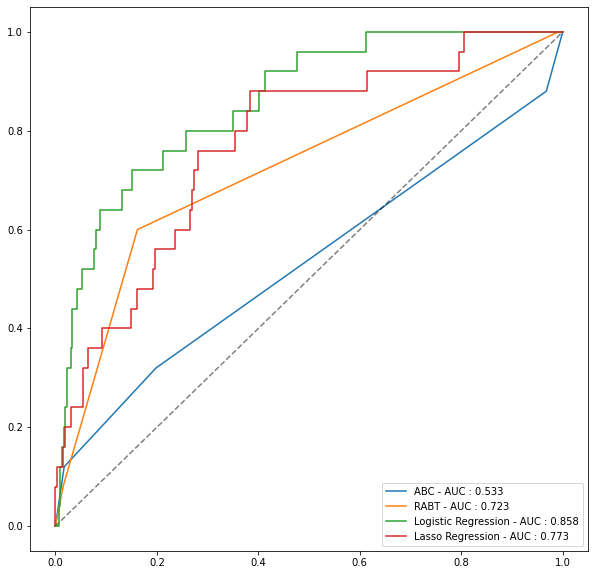

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC'].values
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC'].values

#Scaling the X data using StandarScalar and training only with train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_, columns = X_train.columns)
X_test = pd.DataFrame(X_test_, columns = X_test.columns)

#Training the model with penalty L1
LassoModel = LogisticRegression(
    penalty = 'l1',
    random_state=123,
    max_iter = 10000,
    solver = 'liblinear',
)

#Fitting the model
LassoModel.fit(X_train, y_train)

# Getting the predictions
y_probs_6 = model1.predict_proba(X_test)[:,1]

# Getting the information to plot the ROC curve
fpr_m6, tpr_m6, _ = roc_curve(y_test,  y_probs_6)

#Getting the AUC value
auc_m6 = auc(fpr_m6, tpr_m6)

#Plotting the models
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'Lasso Regression - AUC : {auc_m6:.3f}')
plt.legend(loc='lower right')

### 5-fold cross validation


In [ ]:
#Validating with kfold cross validation
metrics_m6 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):

  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  scaler = StandardScaler()
  scaler.fit(X_train_)
  X_train_ = scaler.transform(X_train_)
  X_test_ = scaler.transform(X_test_)
  X_train_ = pd.DataFrame(X_train_, columns = train_.drop(['PRBC','REFERENCE'], axis = 1).columns)
  X_test_ = pd.DataFrame(X_test_, columns = train_.drop(['PRBC','REFERENCE'], axis = 1).columns)


  LassoModel = LogisticRegression(
      penalty = 'l1',
      random_state=123,
      max_iter = 10000,
      solver = 'liblinear',
  )

  LassoModel.fit(X_train_, y_train_)

  metrics_m6.append((getMetrics(LassoModel, test_)))

#Getting the metrics 
metrics_m6 = pd.DataFrame(metrics_m6, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m6 = pd.DataFrame((metrics_m6.mean(), metrics_m6.std()), index = ['model6-mean', 'model6-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m6), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#Logistic Regression - Ridge

### Base Model

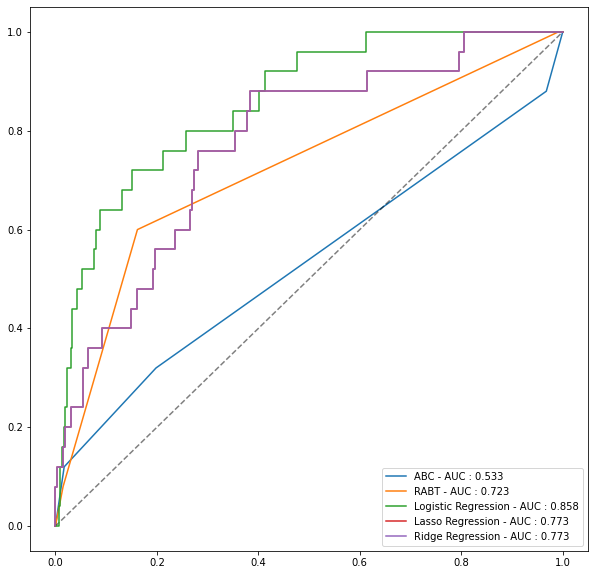

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

#Scaling the X data using StandarScalar and training only with train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_, columns = X_train.columns)
X_test = pd.DataFrame(X_test_, columns = X_test.columns)

#Training the model with penalty L2
RidgeModel = LogisticRegression(
    penalty = 'l2',
    random_state=123,
    max_iter = 10000,
    solver = 'saga'
)

#Fitting the model
RidgeModel.fit(X_train, y_train)

#Getting the predictions
y_probs_7 = model1.predict_proba(X_test)[:,1]

# Getting the information to plot the ROC curve
fpr_m7, tpr_m7, _ = roc_curve(y_test,  y_probs_7)

#Getting the AUC value
auc_m7 = auc(fpr_m7, tpr_m7)

#Plotting the models
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'Lasso Regression - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'Ridge Regression - AUC : {auc_m7:.3f}')
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
#Validating with kfold cross validation
metrics_m7 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  scaler = StandardScaler()
  scaler.fit(X_train_)
  X_train_ = scaler.transform(X_train_)
  X_test_ = scaler.transform(X_test_)
  X_train_ = pd.DataFrame(X_train_, columns = train_.drop(['PRBC','REFERENCE'], axis = 1).columns)
  X_test_ = pd.DataFrame(X_test_, columns = train_.drop(['PRBC','REFERENCE'], axis = 1).columns)


  RidgeModel_ = LogisticRegression(
      penalty = 'l2',
      random_state=123,
      max_iter = 10000,
      solver = 'liblinear',
  )

  RidgeModel_.fit(X_train_, y_train_)

  metrics_m7.append((getMetrics(RidgeModel_, test_)))

#Getting the metrics 
metrics_m7 = pd.DataFrame(metrics_m7, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m7 = pd.DataFrame((metrics_m7.mean(), metrics_m7.std()), index = ['model7-mean', 'model7-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m7), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#Decision Tree

### Base Model

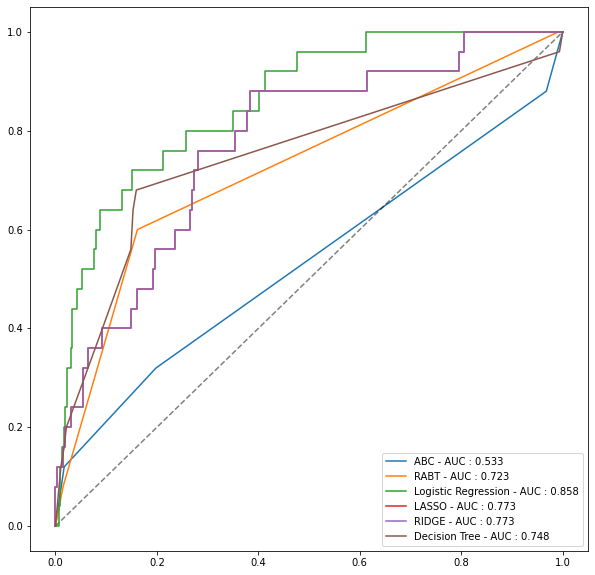

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

#Training the model
Tree = DecisionTreeClassifier( max_depth = 5, random_state=0)
Tree.fit(X_train, y_train)

#Making prediction
y_probs_8 = Tree.predict_proba(X_test)[:,1]

#Getting information for ROC curve
fpr_m8, tpr_m8, _ = roc_curve(y_test,  y_probs_8)

#Getting AUC value
auc_m8 = auc(fpr_m8, tpr_m8)

#Plotting ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8, tpr_m8, label = f'Decision Tree - AUC : {auc_m8:.3f}')
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m8 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  Tree_ = DecisionTreeClassifier( max_depth = 5, random_state=0)
  Tree_.fit(X_train_, y_train_)

  metrics_m8.append((getMetrics(Tree_, test_)))

#Getting the metrics 
metrics_m8 = pd.DataFrame(metrics_m8, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m8 = pd.DataFrame((metrics_m8.mean(), metrics_m8.std()), index = ['model8-mean', 'model8-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m8), axis = 1)
total_metrics_logistic.T

### Fine Tunning

In [ ]:
max_depths = range(1,16) #Max depths vary from 1 to 15
bestMetric = 100

for depth in max_depths:

    model_ = DecisionTreeClassifier( max_depth = depth, random_state=0)
    model_.fit(X_train, y_train)
    alphas = model_.cost_complexity_pruning_path(X_test, y_test).get('ccp_alphas')

    for alpha in alphas: #Here we vary the prune parameter based on the information given at the basic model
      model_ = DecisionTreeClassifier( max_depth = depth, ccp_alpha = alpha, random_state=0)
      model_.fit(X_train, y_train)
      bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test , yTest= y_test)
      metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)
      if metric < bestMetric:
        bestMetric = metric
        bestModel = model_


In [ ]:
bestModel

The best decision tree model has 10 as max_depth and 0.0009887 as prune parameter

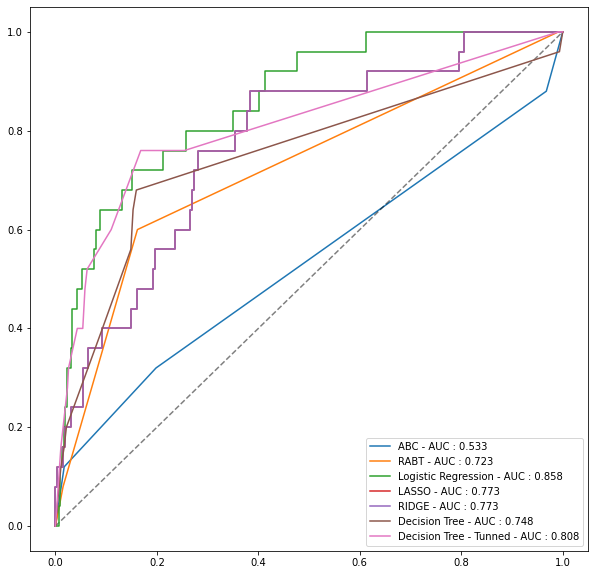

In [ ]:
#comparing the improvement that the fine tunning process had
bestTree = DecisionTreeClassifier(random_state=0, max_depth=10, ccp_alpha=0.0009887126193047547)
bestTree.fit(X_train, y_train)
y_probs_8_tunning = bestTree.predict_proba(X_test)[:,1]

fpr_m8_tunning, tpr_m8_tunning, _ = roc_curve(y_test,  y_probs_8_tunning)

auc_m8_tunning = auc(fpr_m8_tunning, tpr_m8_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8, tpr_m8, label = f'Decision Tree - AUC : {auc_m8:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m8_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  Tree_ = DecisionTreeClassifier( random_state=0, max_depth=10, ccp_alpha=0.0009887126193047547 )
  Tree_.fit(X_train_, y_train_)

  metrics_m8_tunned.append((getMetrics(Tree_, test_)))

#Getting the metrics 
metrics_m8_tunned = pd.DataFrame(metrics_m8_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m8_tunned = pd.DataFrame((metrics_m8_tunned.mean(), metrics_m8_tunned.std()), index = ['model8-tunned-mean', 'model8-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m8_tunned), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#Random Forest

### Base Model

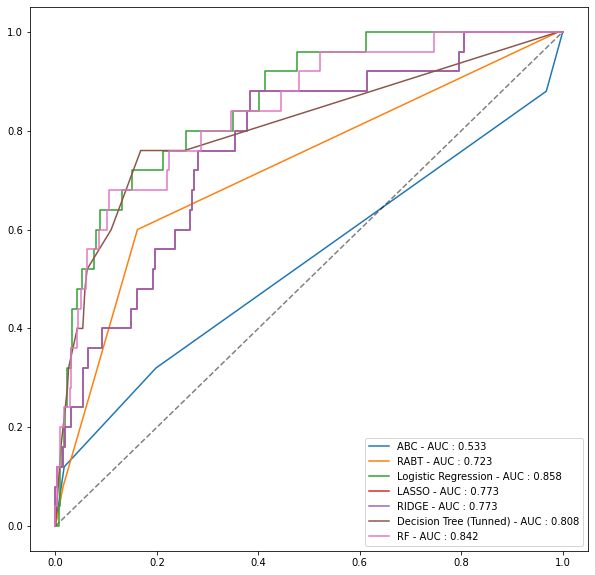

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

#Training the model
RF = RandomForestClassifier( max_depth = 5, random_state=0, n_estimators=1000)
RF.fit(X_train, y_train)

#Making prediction
y_probs_9 = RF.predict_proba(X_test)[:,1]

#Getting information for ROC curve
fpr_m9, tpr_m9, _ = roc_curve(y_test,  y_probs_9)

#Getting AUC value
auc_m9 = auc(fpr_m9, tpr_m9)

#Plotting ROC
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree (Tunned) - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9, tpr_m9, label = f'RF - AUC : {auc_m9:.3f}')
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m9 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  RF_ = RandomForestClassifier( max_depth = 5, random_state=0, n_estimators=1000)
  RF_.fit(X_train_, y_train_)

  metrics_m9.append((getMetrics(RF_, test_)))

#Getting the metrics 
metrics_m9 = pd.DataFrame(metrics_m9, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1', 'distance'])
metrics_m9 = pd.DataFrame((metrics_m9.mean(), metrics_m9.std()), index = ['model9-mean', 'model9-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m9), axis = 1)
total_metrics_logistic.T

### Fine Tunning

In [ ]:
max_depths = range(3,16) #Max depth vary from 3 to 15
trees = np.linspace(100,1000,10) #The number of trees vary from 100 to 1000 10 times
bestMetric = 100

for depth in max_depths:
  for numberTrees in trees:
    model_ = RandomForestClassifier( max_depth = depth, random_state=0, n_estimators = int(numberTrees))
    model_.fit(X_train, y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test , yTest= y_test)
    metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)
    if metric < bestMetric:
      bestMetric = metric
      bestModel = model_

In [ ]:
bestModel

The best model after fine tunning has 8 as depth and 200 trees

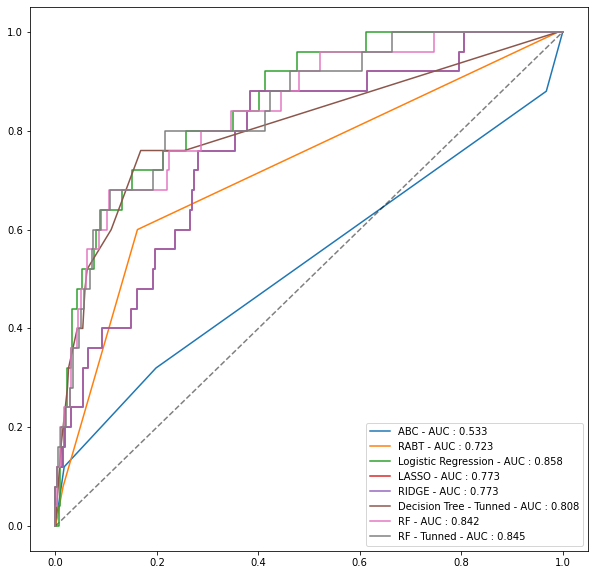

In [ ]:
#Comparing the improvement of fine tunning
bestRF = RandomForestClassifier( max_depth=8, n_estimators=200, random_state=0)
bestRF.fit(X_train, y_train)
y_probs_9_tunning = bestRF.predict_proba(X_test)[:,1]

fpr_m9_tunning, tpr_m9_tunning, _ = roc_curve(y_test,  y_probs_9_tunning)

auc_m9_tunning = auc(fpr_m9_tunning, tpr_m9_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9, tpr_m9, label = f'RF - AUC : {auc_m9:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')

plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m9_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  RF_ = RandomForestClassifier( max_depth=8, n_estimators=200, random_state=0)
  RF_.fit(X_train_, y_train_)

  metrics_m9_tunned.append((getMetrics(RF_, test_)))

#Getting the metrics 
metrics_m9_tunned = pd.DataFrame(metrics_m9_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m9_tunned = pd.DataFrame((metrics_m9_tunned.mean(), metrics_m9_tunned.std()), index = ['model9-tunned-mean', 'model9-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m9_tunned), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#SVM

### Base Model

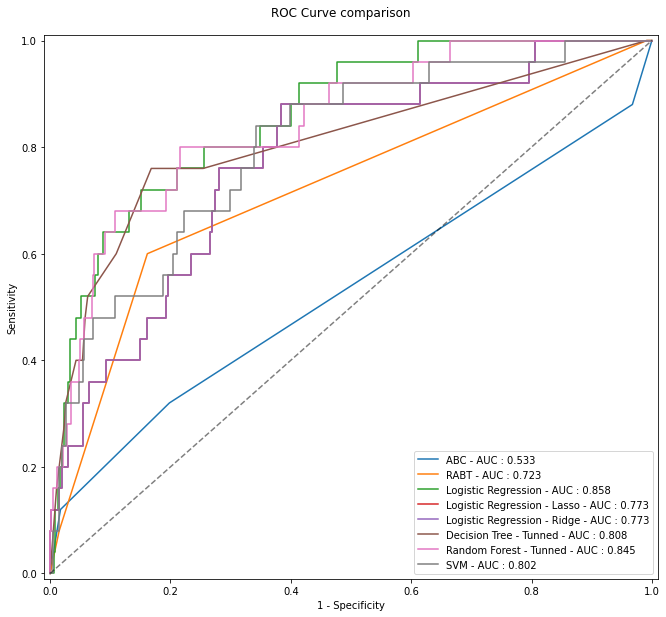

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

#Scaling the X data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_, columns = X_train.columns)
X_test = pd.DataFrame(X_test_, columns = X_test.columns)

#Training the model
SVM = SVC(probability = True)
SVM.fit(X_train, y_train)

#Making predictions
y_probs_10 = SVM.predict_proba(X_test)[:,1]

#Getting information for ROC curve
fpr_m10, tpr_m10, _ = roc_curve(y_test,  y_probs_10)

#Getting the AUC value
auc_m10 = auc(fpr_m10, tpr_m10)

#Plotting ROC curves
plt.figure(figsize=(11,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'Logistic Regression - Lasso - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'Logistic Regression - Ridge - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'Random Forest - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10, tpr_m10, label = f'SVM - AUC : {auc_m10:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m10 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  SVM_ = SVC(probability = True, random_state=0)
  SVM_.fit(X_train_, y_train_)

  metrics_m10.append((getMetrics(SVM_, test_)))

#Getting the metrics 

metrics_m10 = pd.DataFrame(metrics_m10, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1', 'distance'])
metrics_m10 = pd.DataFrame((metrics_m10.mean(), metrics_m10.std()), index = ['model10-mean', 'model10-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m10), axis = 1)
total_metrics_logistic.T

### Fine Tunning

In [ ]:
cValues = np.linspace(1,10,20) #C value vary from 1 to 10, 20 times
kernells = ['linear', 'poly', 'rbf', 'sigmoid'] #The kernells to be tested

bestMetric = 100

for C in cValues:
  for kernel in kernells:
    model_ = SVC(probability = True, kernel = kernel, C = C, max_iter = 10000, random_state=0)
    model_.fit(X_train, y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1, metric = getMetrics(model_, xTest=X_test , yTest= y_test)

    if metric < bestMetric:
      bestKernell = kernel
      bestMetric = metric
      bestModel = model_

In [ ]:
bestModel, bestKernell

The best model for SVM has rbf as kernell function and a C value of 

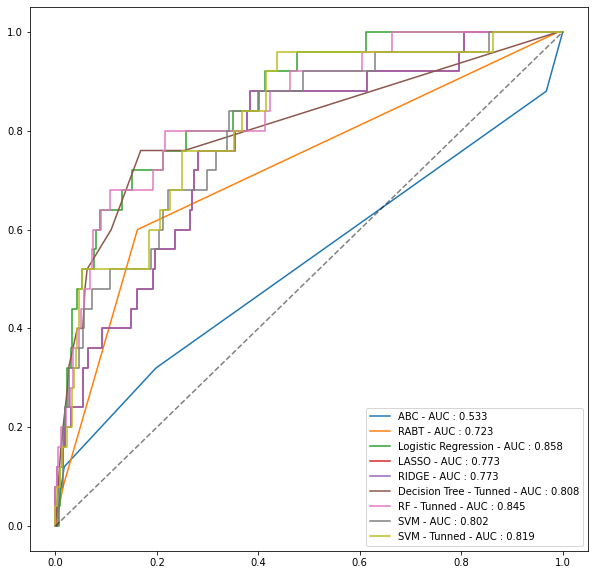

In [ ]:
bestSVM = SVC(C=9.052631578947368, max_iter=10000, probability=True, kernel='rbf')
bestSVM.fit(X_train, y_train)
y_probs_10_tunning = bestSVM.predict_proba(X_test)[:,1]

fpr_m10_tunning, tpr_m10_tunning, _ = roc_curve(y_test,  y_probs_10_tunning)

auc_m10_tunning = auc(fpr_m10_tunning, tpr_m10_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10, tpr_m10, label = f'SVM - AUC : {auc_m10:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])

plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m10_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  SVM_ = SVC(C=9.052631578947368, max_iter=10000, probability=True, kernel='rbf', random_state = 0)
  SVM_.fit(X_train_, y_train_)

  metrics_m10_tunned.append((getMetrics(SVM_, test_)))

#Getting the metrics 
metrics_m10_tunned = pd.DataFrame(metrics_m10_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m10_tunned = pd.DataFrame((metrics_m10_tunned.mean(), metrics_m10_tunned.std()), index = ['model10-tunned-mean', 'model10-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m10_tunned), axis = 1)
total_metrics_logistic.T

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_it

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#XGBoost

### Base Model

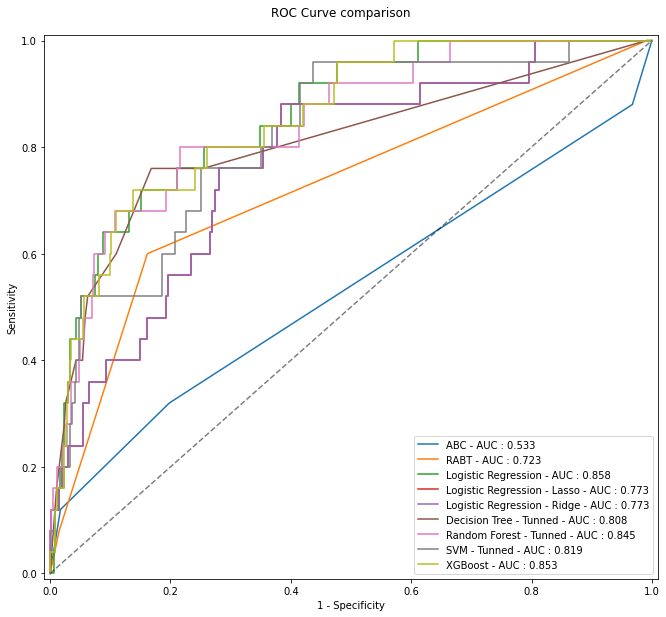

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

#Training the model
XGBoost_Model = XGBClassifier(objective= 'binary:logistic',seed=0)
XGBoost_Model.fit(X_train, y_train)

#Making the predictions
y_probs_11 = XGBoost_Model.predict_proba(X_test)[:,1]

#Getting the information for ROC curve
fpr_m11, tpr_m11, _ = roc_curve(y_test,  y_probs_11)

#Getting AUC value
auc_m11 = auc(fpr_m11, tpr_m11)

#Plottin ROC curves
plt.figure(figsize=(11,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'Logistic Regression - Lasso - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'Logistic Regression - Ridge - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'Random Forest - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11, tpr_m11, label = f'XGBoost - AUC : {auc_m11:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m11 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  XGBoost_Model_ = XGBClassifier(objective= 'binary:logistic',seed=0)
  XGBoost_Model_.fit(X_train_, y_train_)

  metrics_m11.append((getMetrics(XGBoost_Model_, test_)))

#Getting the metrics 
metrics_m11 = pd.DataFrame(metrics_m11, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m11 = pd.DataFrame((metrics_m11.mean(), metrics_m11.std()), index = ['model11-mean', 'model11-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m11), axis = 1)
total_metrics_logistic.T

### Fine Tunning



In [ ]:
max_depths = range(3,16) #Max depth vary from 3 to 15
eta = np.logspace(-4,1,20) #Learing rate, vary from 10e-4 to 10, 20 times
bestMetric = 100

for depth in max_depths:
  for lr in eta:
    model_ = XGBClassifier(objective= 'binary:logistic',seed=0, max_depth=depth, learning_rate = lr)
    model_.fit(X_train, y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test , yTest= y_test)
    metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)
    if metric < bestMetric:
      bestMetric = metric
      bestModel = model_

In [ ]:
bestModel

The best model after fine tunning has 11 as max_depth and a learning rate of 0.0784759

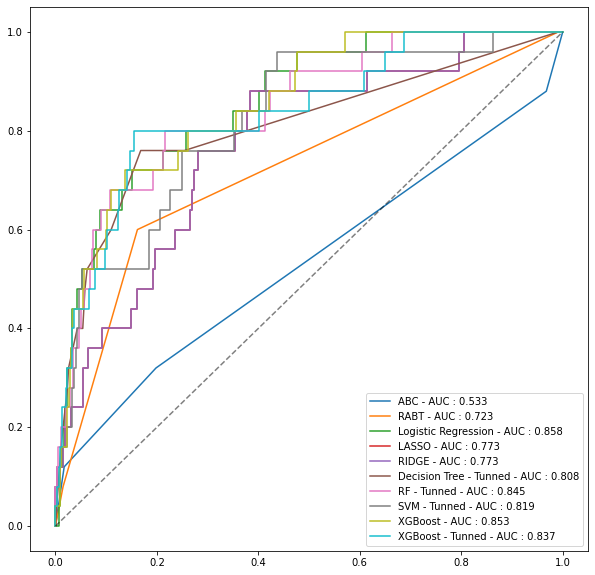

In [ ]:
bestXGB = XGBClassifier(objective= 'binary:logistic',learning_rate=0.07847599703514607, max_depth=11, seed=0)
bestXGB.fit(X_train, y_train)
y_probs_11_tunning = bestXGB.predict_proba(X_test)[:,1]

fpr_m11_tunning, tpr_m11_tunning, _ = roc_curve(y_test,  y_probs_11_tunning)

auc_m11_tunning = auc(fpr_m11_tunning, tpr_m11_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11, tpr_m11, label = f'XGBoost - AUC : {auc_m11:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])

plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m11_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  XGB_ = XGBClassifier(objective= 'binary:logistic',learning_rate=0.07847599703514607, max_depth=11, seed=0)
  XGB_.fit(X_train_, y_train_)

  metrics_m11_tunned.append((getMetrics(XGB_, test_)))

#Getting the metrics 
metrics_m11_tunned = pd.DataFrame(metrics_m11_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m11_tunned = pd.DataFrame((metrics_m11_tunned.mean(), metrics_m11_tunned.std()), index = ['model11-tunned-mean', 'model11-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m11_tunned), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


#Naive Bayes

### Base Model

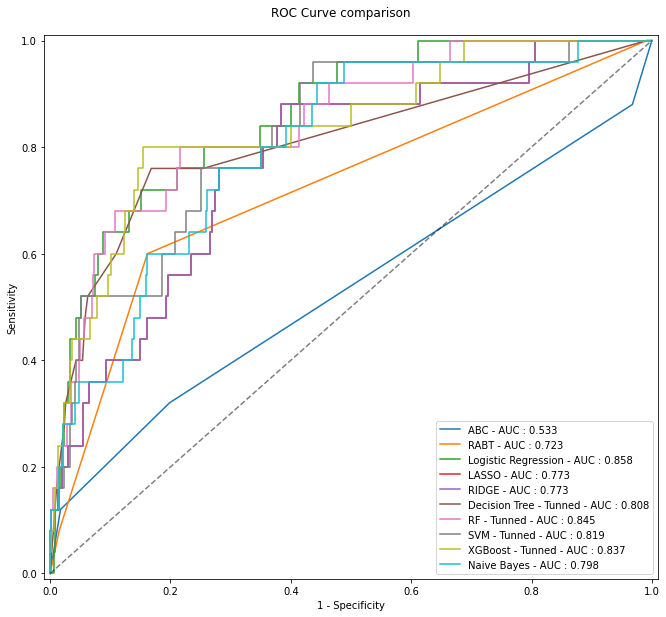

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(X_train, y_train)

y_probs_12 = NaiveBayes_Model.predict_proba(X_test)[:,1]

fpr_m12, tpr_m12, _ = roc_curve(y_test,  y_probs_12)

auc_m12 = auc(fpr_m12, tpr_m12)

plt.figure(figsize=(11,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m12 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  NaiveBates_Model_ = GaussianNB()
  NaiveBates_Model_.fit(X_train_, y_train_)

  metrics_m12.append((getMetrics(NaiveBates_Model_, test_)))

#Getting the metrics 
metrics_m12 = pd.DataFrame(metrics_m12, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1', 'distance'])
metrics_m12 = pd.DataFrame((metrics_m12.mean(), metrics_m12.std()), index = ['model12-mean', 'model12-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m12), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


# ADABOOST

### Base Model

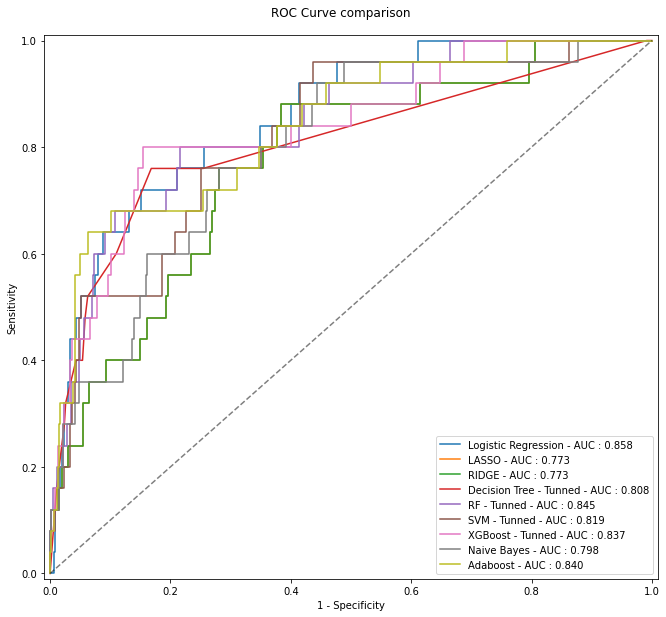

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

adaboost_Model = AdaBoostClassifier(random_state=0)
adaboost_Model.fit(X_train, y_train)

y_probs_13 = adaboost_Model.predict_proba(X_test)[:,1]

fpr_m13, tpr_m13, _ = roc_curve(y_test,  y_probs_13)

auc_m13 = auc(fpr_m13, tpr_m13)

plt.figure(figsize=(11,10))
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot(fpr_m13, tpr_m13, label = f'Adaboost - AUC : {auc_m13:.3f}')

plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m13 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  adaboost_Model_ = AdaBoostClassifier(random_state=0)
  adaboost_Model_.fit(X_train_, y_train_)

  metrics_m13.append((getMetrics(adaboost_Model_, test_)))

#Getting the metrics 

metrics_m13 = pd.DataFrame(metrics_m13, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m13 = pd.DataFrame((metrics_m13.mean(), metrics_m13.std()), index = ['model13-mean', 'model13-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m13), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


### Fine Tunning

In [ ]:
n_estimators = np.linspace(20,100,20) 
bestMetric = 100
estimators = [None, LogisticRegression(random_state=123,solver = 'saga'),SVC(probability = True, max_iter=1000)]
c = 0
for n_estimator in n_estimators:
  for estimator in estimators:
    
    model_ = AdaBoostClassifier(base_estimator = estimator, n_estimators = int(n_estimator), random_state=0)  
    model_.fit(X_train, y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test , yTest= y_test)
    metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)
    if metric < bestMetric:
      bestMetric = metric
      bestModel = model_

In [ ]:
bestModel

AdaBoostClassifier(base_estimator=LogisticRegression(random_state=123,
                                                     solver='saga'),
                   n_estimators=87, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

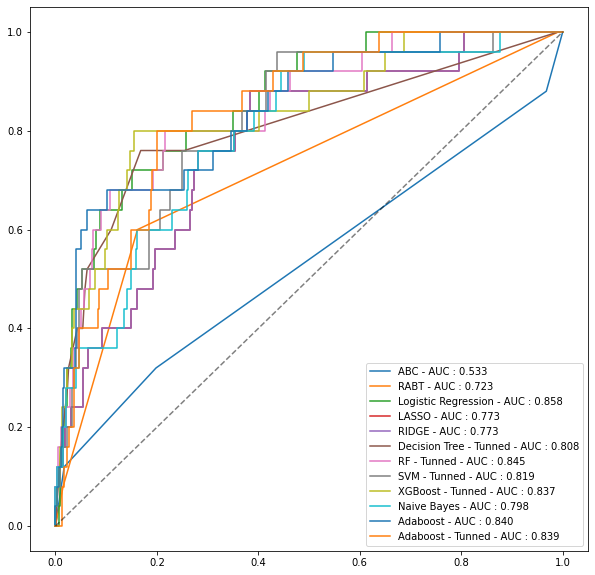

In [ ]:
bestADA = AdaBoostClassifier(
    base_estimator=LogisticRegression(random_state=123, solver='saga'),
    n_estimators=87,
    random_state=0
    )

bestADA.fit(X_train, y_train)
y_probs_13_tunning = bestADA.predict_proba(X_test)[:,1]

fpr_m13_tunning, tpr_m13_tunning, _ = roc_curve(y_test,  y_probs_13_tunning)

auc_m13_tunning = auc(fpr_m13_tunning, tpr_m13_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot(fpr_m13, tpr_m13, label = f'Adaboost - AUC : {auc_m13:.3f}')
plt.plot(fpr_m13_tunning, tpr_m13_tunning, label = f'Adaboost - Tunned - AUC : {auc_m13_tunning:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m13_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  ADA_ = AdaBoostClassifier(
    base_estimator=LogisticRegression(random_state=123, solver='saga'),
    n_estimators=87,
    random_state=0
    )
  ADA_.fit(X_train_, y_train_)

  metrics_m13_tunned.append((getMetrics(ADA_, test_)))

#Getting the metrics 
metrics_m13_tunned = pd.DataFrame(metrics_m13_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m13_tunned = pd.DataFrame((metrics_m13_tunned.mean(), metrics_m13_tunned.std()), index = ['model13-tunned-mean', 'model13-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m13_tunned), axis = 1)
total_metrics_logistic.T

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model1-mean,0.802333,0.806188,0.061884,0.849352,0.181153,0.987358,0.294442,0.282590
model1-std,0.071050,0.039144,0.012380,0.035692,0.028523,0.004519,0.038797,0.050524
model2-mean,0.809333,0.807074,0.056690,0.865442,0.182632,0.987792,0.297416,0.272824
model2-std,0.049281,0.031568,0.010952,0.027324,0.029680,0.003311,0.042098,0.048494
model3-mean,0.875667,0.747071,0.049244,0.840319,0.159628,0.991412,0.268248,0.286189
model3-std,0.051728,0.062235,0.013469,0.022579,0.042416,0.003260,0.059520,0.058808
model4-mean,0.859000,0.763909,0.052097,0.834017,0.162183,0.990508,0.272211,0.279274
model4-std,0.056784,0.039626,0.009013,0.023845,0.026310,0.003656,0.038216,0.042746
model5-mean,0.793000,0.733288,0.050130,0.798336,0.140989,0.985526,0.237805,0.345085
model5-std,0.073185,0.077909,0.011918,0.044610,0.036486,0.004536,0.053212,0.071072


# Neural Network

### Base Model

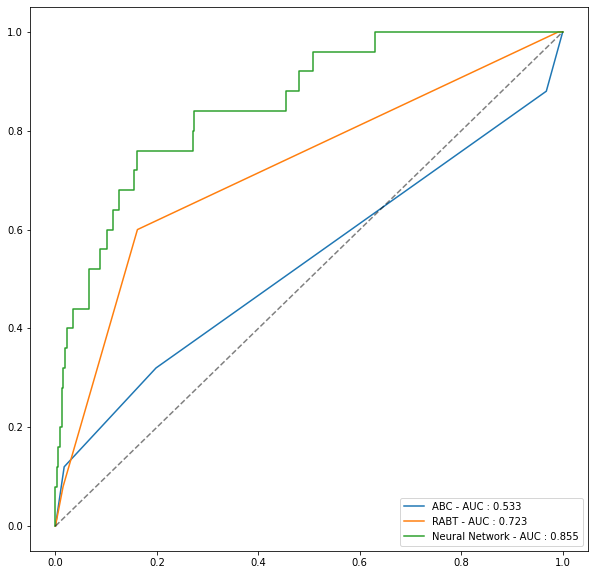

In [ ]:
#Copying the train and test information
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']


#Training the model
NN = MLPClassifier(
    random_state=1,
    max_iter=300
)

#Fitting the model
NN.fit(X_train, y_train)

#Getting the predictions
y_probs_14 = NN.predict_proba(X_test)[:,1]

# Getting the information to plot the ROC curve
fpr_m14, tpr_m14, _ = roc_curve(y_test,  y_probs_14)

#Getting the AUC value
auc_m14 = auc(fpr_m14, tpr_m14)

#Plotting the models
plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot(fpr_m13_tunning, tpr_m13_tunning, label = f'Adaboost - Tunned - AUC : {auc_m13_tunning:.3f}')
plt.plot(fpr_m14, tpr_m14, label = f'Neural Network - AUC : {auc_m14:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.legend(loc='lower right')

### 5-fold cross validation

In [ ]:
metrics_m14 = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  NN_ = MLPClassifier( random_state=1, max_iter=300 )
  NN_.fit(X_train_, y_train_)

  metrics_m14.append((getMetrics(NN_, test_)))

#Getting the metrics 

metrics_m14 = pd.DataFrame(metrics_m14, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m14 = pd.DataFrame((metrics_m14.mean(), metrics_m14.std()), index = ['model14-mean', 'model14-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m14), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model14-mean,0.852000,0.777702,0.037366,0.847796,0.168957,0.990232,0.280971,0.276539
model14-std,0.078213,0.036970,0.018054,0.039627,0.022311,0.005037,0.029221,0.032283


### Fine Tunning

In [ ]:
#Iterating to find the best combination of 4 hidden layers. Each layer can have at least 4 neurons and at most 10 neurons.

bestMetric = 100
for firstLayer in [10,9,8,7,6,5,4]:
  for secondLayer in [10,9,8,7,6,5,4]:
    for thirdLayer in [10,9,8,7,6,5,4]:
      for fourthLayer in [10,9,8,7,6,5,4]:
        print(firstLayer, secondLayer, thirdLayer, fourthLayer)
        model_ = MLPClassifier(hidden_layer_sizes=(firstLayer, secondLayer, thirdLayer, fourthLayer), random_state=1, max_iter=300)

        model_.fit(X_train, y_train)
        bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1, distance = getMetrics(model_, xTest=X_test , yTest= y_test)
        metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)
        if metric < bestMetric:
          bestMetric = metric
          bestModel = model_

In [ ]:
bestModel

MLPClassifier(hidden_layer_sizes=(4, 7, 6, 9), max_iter=300, random_state=1)

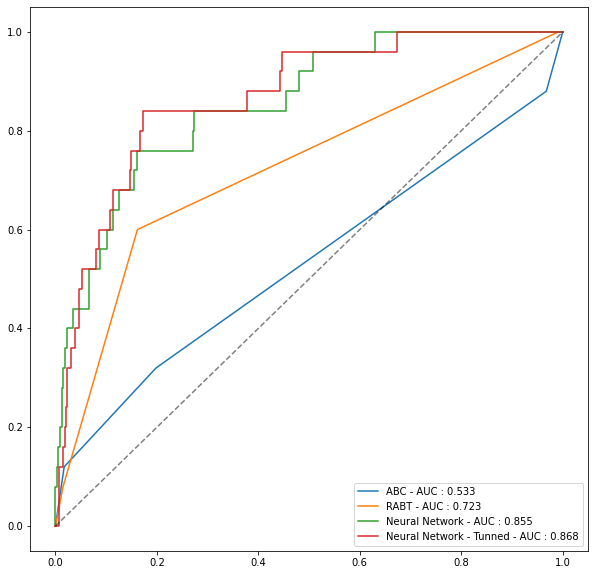

In [ ]:
bestNN = MLPClassifier(hidden_layer_sizes=(4, 7, 6, 9), max_iter=300, random_state=1)

bestNN.fit(X_train, y_train)
y_probs_14_tunning = bestNN.predict_proba(X_test)[:,1]

fpr_m14_tunning, tpr_m14_tunning, _ = roc_curve(y_test,  y_probs_14_tunning)

auc_m14_tunning = auc(fpr_m14_tunning, tpr_m14_tunning)

plt.figure(figsize=(10,10))
plt.plot(fpr_ABC, tpr_ABC, label = f'ABC - AUC : {auc_ABC:.3f}')
plt.plot(fpr_RABT, tpr_RABT, label = f'RABT - AUC : {auc_RABT:.3f}')
plt.plot(fpr_m14, tpr_m14, label = f'Neural Network - AUC : {auc_m14:.3f}')
plt.plot(fpr_m14_tunning, tpr_m14_tunning, label = f'Neural Network - Tunned - AUC : {auc_m14_tunning:.3f}')

plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.legend(loc='lower right')

### CV Fine Tunning

In [ ]:
metrics_m14_tunned = []
for train_, test_ in zip(dataTrain_kfold.copy(), dataTest_kfold.copy()):
  X_test_ = test_.drop(['PRBC','REFERENCE'], axis = 1)
  y_test_ = test_['PRBC'].values
  X_train_ = train_.drop(['PRBC','REFERENCE'], axis = 1)
  y_train_ = train_['PRBC'].values

  NN_ = MLPClassifier(hidden_layer_sizes=(4, 7, 6, 9), max_iter=300, random_state=1)
  NN_.fit(X_train_, y_train_)

  metrics_m14_tunned.append((getMetrics(NN_, test_)))

#Getting the metrics 
metrics_m14_tunned = pd.DataFrame(metrics_m14_tunned, columns = ['bestSensitivity', 'bestSpecificity', 'bestThr', 'aucValue', 'ppv', 'fpv', 'f1','distance'])
metrics_m14_tunned = pd.DataFrame((metrics_m14_tunned.mean(), metrics_m14_tunned.std()), index = ['model14-tunned-mean', 'model14-tunned-std']).T
total_metrics_logistic = pd.concat((total_metrics_logistic,metrics_m14_tunned), axis = 1)
total_metrics_logistic.T

,bestSensitivity,bestSpecificity,bestThr,aucValue,ppv,fpv,f1,distance
model14-tunned-mean,0.818000,0.788081,0.058335,0.828223,0.175014,0.988090,0.286285,0.285611
model14-tunned-std,0.063699,0.055655,0.017012,0.055015,0.043114,0.004203,0.058004,0.052250


# Forward Feature Selection

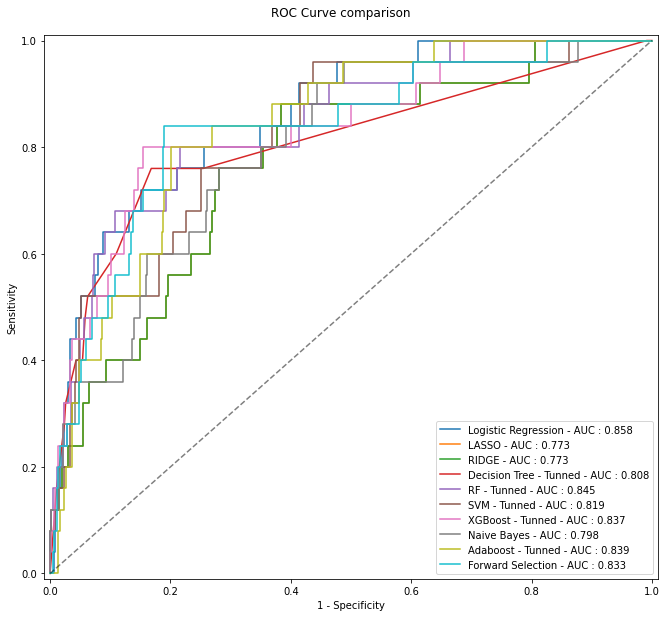

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

total_columns = list(X_test.columns)
best_variables = []

best_metric = 100
condition = True
while condition:
  best_metric_temp = 100
  
  for variable in total_columns:

    to_test = best_variables + [variable]
    X_test_, X_train_ = X_test[to_test].copy(), X_train[to_test].copy()
    model_ = LogisticRegression(
        random_state=123,
        penalty = 'none',
        max_iter = 10000,
        solver = 'saga'
    )

    model_.fit(X_train_,y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test_ , yTest= y_test)
    test_metrics = [bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1]
    metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)

    if metric < best_metric_temp:
      best_metric_temp = metric
      best_variable = variable
      best_test_metrics = test_metrics
      best_model_temp = model_

  if best_metric_temp < best_metric:
    best_metric = best_metric_temp
    best_variables.append(best_variable)
    total_columns.remove(best_variable)
    best_model = best_model_temp
    
  else:
    condition = False

y_probs_13 = best_model.predict_proba(X_test[best_variables])[:,1]

fpr_m13, tpr_m13, _ = roc_curve(y_test,  y_probs_13)

auc_m13 = auc(fpr_m13, tpr_m13)

plt.figure(figsize=(11,10))
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot(fpr_m13_tunning, tpr_m13_tunning, label = f'Adaboost - Tunned - AUC : {auc_m13_tunning:.3f}')
plt.plot(fpr_m13, tpr_m13, label = f'Forward Selection - AUC : {auc_m13:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

# Backward Selection

['SBP', 'DBP', 'RR', 'O2', 'HR', 'GCSEO', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.27789232692297117
['AGE', 'SBP', 'RR', 'O2', 'HR', 'GCSEO', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.2585114711907724
['SBP', 'RR', 'O2', 'HR', 'GCSEO', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.2792529874057389
['AGE', 'SBP', 'O2', 'HR', 'GCSEO', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.2585114711907724
['AGE', 'SBP', 'RR', 'O2', 'HR', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.24855840304949667
['SBP', 'RR', 'O2', 'HR', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.26763443008859417
['AGE', 'SBP', 'O2', 'HR', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.2464878293141469
['AGE', 'SBP', 'RR', 'HR', 'GCSVR', 'GCSMR', 'PLRN', 'PLRA', 'SPF', 'FC', 'FRLPA', 'PNR', 'BLR'] 0.2317613373261197
['AGE', 'SBP', 'R

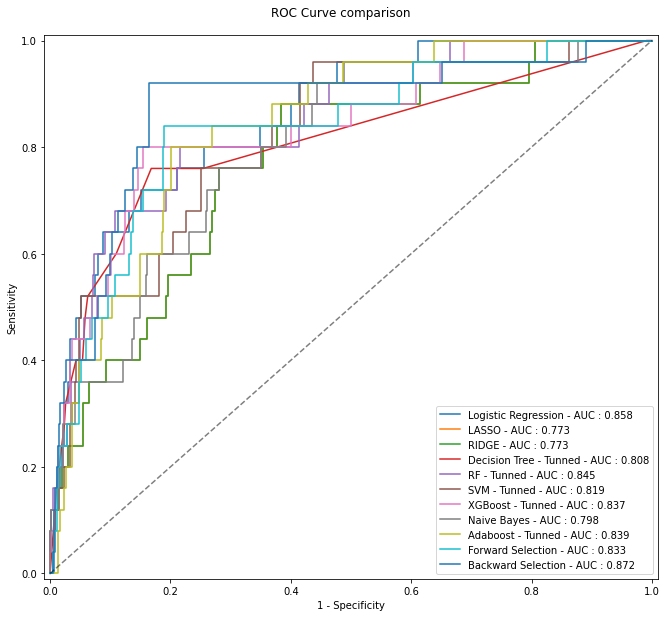

In [ ]:
X_test = dataTest.drop(['PRBC','REFERENCE'], axis = 1)
y_test = dataTest['PRBC']
X_train = dataTrain.drop(['PRBC','REFERENCE'], axis = 1)
y_train = dataTrain['PRBC']

total_columns = list(X_test.columns)

best_metric = 100
condition = True
while condition:
  best_metric_temp = 100
  
  for variable in total_columns:

    to_test = total_columns.copy()
    to_test.remove(variable)
    X_test_, X_train_ = X_test[to_test].copy(), X_train[to_test].copy()
    model_ = LogisticRegression(
        random_state=143,
        penalty = 'none',
        max_iter = 10000,
        solver = 'saga'
    )

    model_.fit(X_train_,y_train)
    bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1 = getMetrics(model_, xTest=X_test_ , yTest= y_test)
    test_metrics = [bestSensitivity, bestSpecificity, bestThr, aucValue, ppv, fpv, f1]
    metric = ((1-bestSensitivity) ** 2 + (1-bestSpecificity)**2)**(1/2)

    if metric < best_metric_temp:
      best_metric_temp = metric
      best_variable = variable
      best_test_metrics = test_metrics
      best_model_temp = model_
      print(to_test, metric)

  if best_metric_temp < best_metric:
    best_metric = best_metric_temp
    total_columns.remove(best_variable)
    best_model = best_model_temp
    
  else:
    condition = False

y_probs_14 = best_model.predict_proba(X_test[total_columns])[:,1]

fpr_m14, tpr_m14, _ = roc_curve(y_test,  y_probs_14)

auc_m14 = auc(fpr_m14, tpr_m14)

plt.figure(figsize=(11,10))
plt.plot(fpr_m1, tpr_m1, label = f'Logistic Regression - AUC : {auc_m1:.3f}')
plt.plot(fpr_m6, tpr_m6, label = f'LASSO - AUC : {auc_m6:.3f}')
plt.plot(fpr_m7, tpr_m7, label = f'RIDGE - AUC : {auc_m7:.3f}')
plt.plot(fpr_m8_tunning, tpr_m8_tunning, label = f'Decision Tree - Tunned - AUC : {auc_m8_tunning:.3f}')
plt.plot(fpr_m9_tunning, tpr_m9_tunning, label = f'RF - Tunned - AUC : {auc_m9_tunning:.3f}')
plt.plot(fpr_m10_tunning, tpr_m10_tunning, label = f'SVM - Tunned - AUC : {auc_m10_tunning:.3f}')
plt.plot(fpr_m11_tunning, tpr_m11_tunning, label = f'XGBoost - Tunned - AUC : {auc_m11_tunning:.3f}')
plt.plot(fpr_m12, tpr_m12, label = f'Naive Bayes - AUC : {auc_m12:.3f}')
plt.plot(fpr_m13_tunning, tpr_m13_tunning, label = f'Adaboost - Tunned - AUC : {auc_m13_tunning:.3f}')
plt.plot(fpr_m13, tpr_m13, label = f'Forward Selection - AUC : {auc_m13:.3f}')
plt.plot(fpr_m14, tpr_m14, label = f'Backward Selection - AUC : {auc_m14:.3f}')
plt.plot([0,1],[0,1], '--', c = [0,0,0,0.5])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.xlim((-0.01,1.01))
plt.ylim((-0.01,1.01))
plt.suptitle('ROC Curve comparison',y=0.92)
plt.legend(loc='lower right')

# Exporting AUC info

In [ ]:
ABC_data = pd.DataFrame({'1-spec - ABC' : fpr_ABC, 'sens - ABC': tpr_ABC})
RABT_data = pd.DataFrame({'1-spec - RABT' : fpr_RABT, 'sens - RABT': tpr_RABT})
logistic_data = pd.DataFrame({'1-spec - Logistic' : fpr_m1, 'sens - Logistic': tpr_m1})
lasso_data = pd.DataFrame({'1-spec - lasso' : fpr_m6, 'sens - lasso': tpr_m6})
ridge_data = pd.DataFrame({'1-spec - ridge' : fpr_m7, 'sens - ridge': tpr_m7})
CART_data = pd.DataFrame({'1-spec - CART' : fpr_m8_tunning, 'sens - CART': tpr_m8_tunning})
RF_data = pd.DataFrame({'1-spec - RF' : fpr_m9_tunning, 'sens - RF': tpr_m9_tunning})
SVM_data = pd.DataFrame({'1-spec - SVM' : fpr_m10_tunning, 'sens - SVM': tpr_m10_tunning})
XGB_data = pd.DataFrame({'1-spec - XGB' : fpr_m11_tunning, 'sens - XGB': tpr_m11_tunning})
naive_data = pd.DataFrame({'1-spec - naive' : fpr_m12, 'sens - naive': tpr_m12})
ADA_data = pd.DataFrame({'1-spec - ADA' : fpr_m13_tunning, 'sens - ADA': tpr_m13_tunning})
NN_data = pd.DataFrame({'1-spec - NN' : fpr_m14_tunning, 'sens - NN': tpr_m14_tunning})
AUC_DATA = pd.concat((
    ABC_data,
    RABT_data,
    logistic_data,
    lasso_data,
    ridge_data,
    CART_data,
    RF_data,
    SVM_data,
    XGB_data,
    naive_data,
    ADA_data,
    NN_data
    ),
    axis = 1)

AUC_DATA.to_csv('auc_data.csv',index = False)